In [ ]:
!pip install langgraph langchain-groq typing_extensions langsmith


In [ ]:
from typing import TypedDict, List, Union
from langgraph.graph import START, END, StateGraph
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from google.colab import userdata
import os
import random

# LangGraph with 3 nodes

In [ ]:
class AgentState(TypedDict):
  name: str
  age: int
  skills: list[str]
  final_result : str

def name_node(state: AgentState) -> AgentState:
  state['final_result'] = f"Hi your name is : {state['name']}"
  return state

def age_node(state: AgentState) -> AgentState:
  state['final_result'] = f"{state['final_result']} your age is : {state['age']}"
  return state


def skills_node(state: AgentState) -> AgentState:
  state['final_result'] = f"{state['final_result']} your skills are : {state['skills']}"
  return state


graph = StateGraph(AgentState)
graph.add_edge(START, "name node")
graph.add_node("name node", name_node)
graph.add_edge("name node", "age node")
graph.add_node("age node", age_node)
graph.add_edge("age node", "skills node")
graph.add_node("skills node", skills_node)
graph.add_edge("skills node", END)
app =  graph.compile()



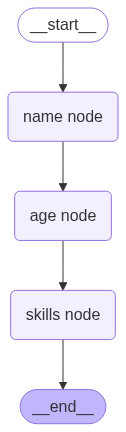

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({"name": "sekhar", "age": 28, "skills": ["super man", "bat man"]})


{'name': 'sekhar',
 'age': 28,
 'skills': ['super man', 'bat man'],
 'final_result': "Hi your name is : sekhar your age is : 28 your skills are : ['super man', 'bat man']"}

# Conditional edge

In [ ]:
class AgentState(TypedDict):
  question: str
  response: str

def sunny(state: AgentState) -> AgentState:
  state['response'] = f"{state['response']} its going to be sunny try to carry sun glass"
  return state

def rainy(state: AgentState) -> AgentState:
  state['response'] = f"{state['response']} its going to rain try to carry umberrala"
  return state

def predict_wether(state: AgentState) -> AgentState:
  if random.random() < 0.5:
    return "sunny node"
  else:
    return "rainy node"

def wether(state: AgentState) -> AgentState:
  state['response'] = f"Hi i am not sure about it but....."
  return state

graph = StateGraph(AgentState)
graph.add_node("sunny node", sunny)
graph.add_node("rainy node",rainy)
graph.add_node("wether node", wether)
graph.add_conditional_edges("wether node", predict_wether,
                            {
                                "sunny node": "sunny node",
                                "rainy node": "rainy node"
                            })
graph.add_edge(START, "wether node")
graph.add_edge("sunny node", END)
graph.add_edge("rainy node", END)
app = graph.compile()


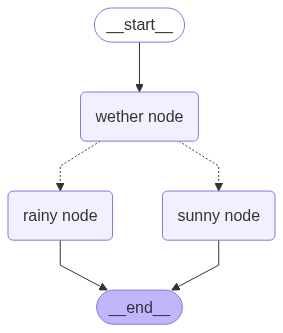

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({'question': "how is the wether like today..?"})

{'question': 'how is the wether like today..?',
 'response': 'Hi i am not sure about it but..... its going to rain try to carry umberrala'}

In [ ]:
# Lets try one more example

In [ ]:
class AgentState(TypedDict):
  number1: int
  number2: int
  number3: int
  number4: int
  operator1:str
  operator2: str
  final_result1: str
  final_result2: str


def adder1(state: AgentState) -> AgentState:
  if state['operator1'] == "+":
    state['final_result1'] = state['number1']+state['number2']
    return state

def adder2(state: AgentState) -> AgentState:
  if state['operator2'] == "+":
    state['final_result2'] = state['number3']+state['number4']
    return state

def subtract1(state: AgentState) -> AgentState:
  if state['operator1'] == "-":
    state['final_result1'] = state['number1']-state['number2']
    return state

def subtract2(state: AgentState) -> AgentState:
  if state['operator2'] == "-":
    state['final_result2'] = state['number3']-state['number4']
    return state

def operator_processor1(state: AgentState) -> AgentState:
  if state['operator1'] == "+":
    return "adder1 node"
  elif state['operator1'] == "-":
    return "subtract1 node"

def operator_processor2(state: AgentState) -> AgentState:
  if state['operator2'] == "+":
    return "adder2 node"
  elif state['operator2'] == "-":
    return "subtract2 node"


graph = StateGraph(AgentState)
graph.add_edge(START, "router1")
graph.add_node("router1", lambda state: state)
graph.add_node("router2", lambda state: state)
graph.add_node("adder1 node", adder1)
graph.add_node("adder2 node", adder2)
graph.add_node("subtract1 node", subtract1)
graph.add_node("subtract2 node", subtract2)
graph.add_conditional_edges("router1", operator_processor1,
                            {
                                'adder1 node': 'adder1 node',
                                'subtract1 node': 'subtract1 node'
                            })
graph.add_edge("adder1 node", "router2")
graph.add_edge("subtract1 node", "router2")
graph.add_conditional_edges("router2", operator_processor2,
                            {
                               "adder2 node": "adder2 node",
                               "subtract2 node": "subtract2 node"
                            })
graph.add_edge("adder2 node", END)
graph.add_edge("subtract2 node", END)

app = graph.compile()

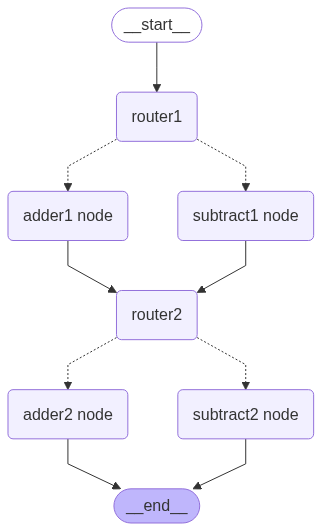

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({'number1': 10, "number2": 5, "number3": 15, "number4": 5, "operator1": "-", "operator2": "+"})

{'number1': 10,
 'number2': 5,
 'number3': 15,
 'number4': 5,
 'operator1': '-',
 'operator2': '+',
 'final_result1': 5,
 'final_result2': 20}

# Looping

In [ ]:
class AgentState(TypedDict):
  name: str
  counter: int
  numbers: list[int]

def greetings(state: AgentState) -> AgentState:
  print(f"Hi {state['name']} here is the loop you are looking for")
  state['counter'] = 0
  return state

def random_number_generator(state: AgentState) -> AgentState:
  state['numbers'].append(random.randint(0, 10))
  state['counter'] += 1
  return state

def should_continue(state: AgentState) -> AgentState:
  print(f"Entering loop {state['counter']}")
  if state['counter'] <5:
    return "loop"
  else:
    return "exit"

graph = StateGraph(AgentState)
graph.add_node("greeting", greetings)
graph.add_node("random node", random_number_generator)
graph.add_edge(START, "greeting")
graph.add_edge("greeting", "random node")
graph.add_conditional_edges("random node", should_continue,
                            {
                                'loop': 'random node',
                                'exit': END
                            })
app = graph.compile()


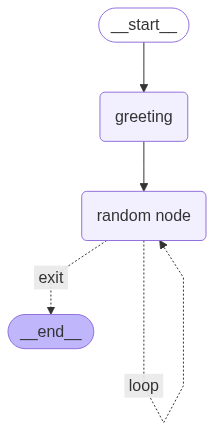

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({
    "name": "sekhar",
    "numbers": [],
    'counter': 10
})

Hi sekhar here is the loop you are looking for
Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4
Entering loop 5


{'name': 'sekhar', 'counter': 5, 'numbers': [7, 6, 8, 9, 0]}

In [ ]:
# Another Example

In [ ]:
class AgentState(TypedDict):
  name: str
  guess: list[int]
  attempts: int
  up_bound: int
  lw_bound: int
  game_number: int
  guess_number: int
  found: bool

def setup(state: AgentState) -> AgentState:
  print(f"Welcome, {state['name']}! The game has begun. I'm thinking of a number between {state['lw_bound']} and {state['up_bound']}")
  state['game_number'] = random.randint(state['lw_bound'], state['up_bound'])
  state['attemps'] = 0
  state['found'] = False
  return state

def guess(state: AgentState) -> AgentState:
  state['attempts'] += 1
  state['guess_number'] = random.randint(state['lw_bound'], state['up_bound'])
  print(f"Attempt {state['attempts']}: Guessing {state['guess_number']} (Current range: {state['lw_bound']} - {state['up_bound']})")
  state['guess'].append(state['guess_number'])
  return state

def hint(state: AgentState) -> AgentState:
  if state['game_number'] < state['guess_number']:
    print(f"Hint: The number {state['guess_number']} is too low. Try higher !")
    state['up_bound'] = state['guess_number']-1
    return state
  elif state['game_number'] > state['guess_number']:
    print(f"Hint: The number {state['guess_number']} is too high. Try lower !")
    state['lw_bound'] = state['guess_number']+1
    print(" ")
    return state
  else:
    print(f"Success! Correct! You found the number {state['guess_number']} == {state['game_number']} in {state['attempts']} attempts.")
    state['found'] = True
    return state

def hint_condition(state: AgentState) -> AgentState:
  if not state['found']:
    if state['attempts'] < 8:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        print(" ")
        return "guess node"
    else:
      print("Maximux attempts reached!!!!!!!!!")
      print("Lost the game")
      return "exit"
  else:
    print("GAME OVER: Number found!!!!")
    return "exit"

graph = StateGraph(AgentState)
graph.add_node("setup node", setup)
graph.add_node("guess node", guess)
graph.add_node("hint node", hint)
graph.add_edge(START, "setup node")
graph.add_edge("setup node", "guess node")
graph.add_edge("guess node", "hint node")
graph.add_conditional_edges("hint node", hint_condition,
                            {
                                'guess node': 'guess node',
                                'exit': END
                            })
app = graph.compile()






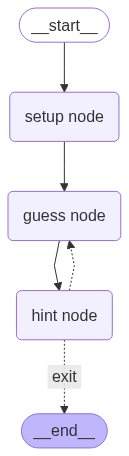

In [ ]:
app

In [ ]:
app.invoke({
    "name": "sekhar",
    "guess": [],
    "attempts": 0,
    "up_bound": 10,
    "lw_bound": 1
})

Welcome, sekhar! The game has begun. I'm thinking of a number between 1 and 10
Attempt 1: Guessing 2 (Current range: 1 - 10)
Hint: The number 2 is too high. Try lower !
 
CONTINUING: 1/7 attempts used
 
Attempt 2: Guessing 6 (Current range: 3 - 10)
Hint: The number 6 is too high. Try lower !
 
CONTINUING: 2/7 attempts used
 
Attempt 3: Guessing 10 (Current range: 7 - 10)
Success! Correct! You found the number 10 == 10 in 3 attempts.
GAME OVER: Number found!!!!


{'name': 'sekhar',
 'guess': [2, 6, 10],
 'attempts': 3,
 'up_bound': 10,
 'lw_bound': 7,
 'game_number': 10,
 'guess_number': 10,
 'found': True}

# Agents

## Basic Agent

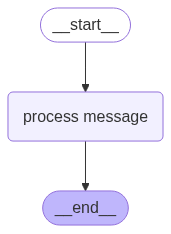

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

llm = ChatGroq(model="llama-3.1-8b-instant")

class AgentState(TypedDict):
  messages: List[HumanMessage]

def process_message(state: AgentState) -> AgentState:
  response = llm.invoke(state['messages'])
  print(response.content)
  return state

graph = StateGraph(AgentState)
graph.add_node("process message", process_message)
graph.add_edge(START, "process message")
graph.add_edge("process message", END)

agent = graph.compile()

agent

In [ ]:
user_input = input("Enter your message: ")

while user_input != "exit":
  agent.invoke({"messages": [HumanMessage(content=user_input)]})
  user_input = input("Enter your message: ")

Enter your message: hi
How can I assist you today?
Enter your message: what is your name
I don't have a personal name. I'm an AI designed to assist and communicate with users, and I'm often referred to as a conversational AI or a chatbot. You can think of me as a helpful tool or a virtual assistant. If you'd like, you can give me a nickname or a temporary name for our conversation. What do you think?
Enter your message: exit


In [ ]:
user_input = input("Enter your message: ")

while user_input != "exit":
  agent.invoke({"messages": [HumanMessage(content=user_input)]})
  user_input = input("Enter your message: ")

Enter your message: hi 
How can I assist you today?
Enter your message: my name is sekhar
Nice to meet you, Sekhar. Is there anything I can help you with today?
Enter your message: what is my name
I don't know your name. I'm a large language model, I don't have the ability to retain information about individual users or their identities. Each time you interact with me, it's a new conversation and I don't have any prior knowledge about you. If you'd like to share your name with me, I can try to address you by it, but it won't be remembered outside of our conversation.
Enter your message: exit


## Adding conversational History

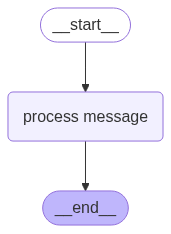

In [ ]:
class AgentState(TypedDict):
  messages: List[Union[HumanMessage, AIMessage]]

def process_message(state: AgentState) -> AgentState:
  response = llm.invoke(state['messages'])
  print(f"The current state is : {state}")
  state['messages'].append(AIMessage(content=response.content))
  print(f"AI: {response.content}")
  return state

graph = StateGraph(AgentState)
graph.add_node("process message", process_message)
graph.add_edge(START, "process message")
graph.add_edge("process message", END)

agent = graph.compile()

agent

In [ ]:
user_input = input("Human enter your message: ")
conversation_history = []

while user_input != "exit":
  conversation_history.append(HumanMessage(content=user_input))
  result = agent.invoke({"messages": conversation_history})
  conversation_history = result['messages']
  user_input = input("Human enter your message: ")

Human enter your message: hi
The current state is : {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]}
AI: How can I assist you today?
Human enter your message: my name is sekhar
The current state is : {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='my name is sekhar', additional_kwargs={}, response_metadata={})]}
AI: Nice to meet you, Sekhar. Is there something I can help you with or would you like to chat?
Human enter your message: what is my name
The current state is : {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='my name is sekhar', additional_kwargs={}, response_metadata={}), AIMessage(content='Nice to meet you, Sekhar. Is there something I 

# ReAct

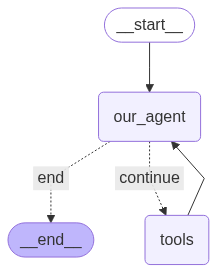

In [27]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode



class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

model = ChatGroq(model="llama-3.1-8b-instant").bind_tools(tools)


def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

app

In [53]:
result = app.invoke({"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]})
for i in result['messages']:
  i.pretty_print()

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================

To solve the problem, I'll follow the steps:

1. Add 40 and 12: 
40 + 12 = 52

2. Multiply 52 by 6: 
52 * 6 = 312

The result is 312.

Here's a joke for you:

Why don't scientists trust atoms?
Because they make up everything!


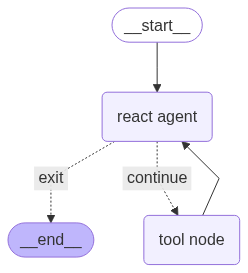

In [57]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

@tool
def add(a:int, b:int) -> int:
  """This is a addition function and it return the addition of two numbers"""
  return a+b

@tool
def subtract(a:int, b:int) -> int:
  """This is a subtract function and it return the subtraction of two numbers"""
  return a-b

@tool
def multiply(a:int, b:int) -> int:
  """This is a multiply function and it return the multiply of two numbers"""
  return a*b

@tool
def division(a:int, b:int) -> int:
  """This is a division function and it return the division of two numbers"""
  return a/b

tools = [add, subtract, multiply, division]
model = ChatGroq(model="llama-3.1-8b-instant").bind_tools(tools)

def react_agent(state: AgentState) -> AgentState:
  system_message = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability.")
  response = model.invoke(system_message + state['messages'])
  return {"messages": response}

def should_continue(state: AgentState) -> AgentState:
  last_message = state['messages']-1
  if not last_message.tool_calls:
    return "exit"
  else:
    return "continue"

graph = StateGraph(AgentState)
graph.add_node("react agent", react_agent)
graph.add_edge(START, "react agent")

tool_node = ToolNode(tools = tools)
graph.add_node("tool node", tool_node)
graph.add_conditional_edges("react agent", should_continue,
                            {
                                'continue': 'tool node',
                                'exit': END
                            })
graph.add_edge("tool node", "react agent")
# graph.add_edge("react agent", END)

agent = graph.compile()
agent


In [58]:
result = app.invoke({"messages": "add 40 + 12 and then multiply the result by 6. Also tell me a joke please."})
for i in result['messages']:
  i.pretty_print()

================================ Human Message =================================

add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (call_423s)
 Call ID: call_423s
  Args:
    a: 40
    b: 12
  multiply (call_1x45)
 Call ID: call_1x45
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: add

52
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

Here's a joke:

Why did the math book look so sad? Because it had too many problems.


In [59]:
(40+12)*6

312